In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
import torch.optim as optim
import warnings
import numpy as np
from torch.nn import Parameter
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from PIL import Image

warnings.filterwarnings('ignore') 
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [2]:
class BIRADSDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.samples = []
        
        for label in self.classes:
            patient_dirs = os.listdir(os.path.join(root_dir, label))
            for patient_id in patient_dirs:
                patient_dir = os.path.join(root_dir, label, patient_id)
                images = os.listdir(patient_dir)
                if len(images) == 2:  
                    image_paths = [os.path.join(patient_dir, img) for img in images]
                    self.samples.append((image_paths, label))
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_paths, label = self.samples[idx]
        images = [Image.open(img_path).convert('RGB') for img_path in image_paths]
        
        if self.transform:
            images = [self.transform(img) for img in images]

        label = 0 if 'BIRADS12' in label else 1 
        
        return (images[0], images[1]), label

In [ ]:
data_dir = r"BIRADS12_45DatasetwTest"
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')
# Transforms
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2),
    transforms.Resize((520, 520)),
    transforms.RandomCrop((500, 500)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
valid_transforms = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = BIRADSDataset(train_dir, transform=train_transforms)
valid_dataset = BIRADSDataset(valid_dir, transform=valid_transforms)
test_dataset = BIRADSDataset(test_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [5]:
train_dataset.classes

['BIRADS12', 'BIRADS45']

In [6]:
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

147
19
5


In [7]:
valid_dataset.classes

['BIRADS12', 'BIRADS45']

In [8]:
test_dataset.classes

['BIRADS12', 'BIRADS45']

In [9]:
class WeightedDoubleClassifier(nn.Module):
    def __init__(self, in_features, out_features, n=2):
        super(WeightedDoubleClassifier, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.n = n
        self.base = 1000.0
        self.iter = 0
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
    
    def forward(self, input, label):
        self.iter += 1

        cos_theta = F.linear(F.normalize(input), F.normalize(self.weight))
        cos_theta = cos_theta.clamp(-1, 1)
        theta = cos_theta.data.acos()

        phi1 = torch.cat([cos_theta[:,0].view(-1,1)*self.n, cos_theta[:,1].view(-1,1)],dim=1)
        phi2 = torch.cat([cos_theta[:,0].view(-1,1), cos_theta[:,1].view(-1,1)*self.n,],dim=1)
        output1 =  phi1 * torch.norm(input, 2, 1).view(-1, 1)
        output2 = phi2 * torch.norm(input, 2, 1).view(-1, 1)
        output_std = cos_theta * torch.norm(input, 2, 1).view(-1, 1)
        return output1, output2, output_std

### ResNet18 and ResNet50 with WDC classifier head

In [ ]:
class CNN_ResNet18(nn.Module): 
    def __init__(self, model):
        super(CNN_ResNet18, self).__init__()
        self.resnet_layer = nn.Sequential(*list(model.children())[:-1])
        self.avp_pooling = nn.AdaptiveAvgPool2d((1, 1)) 
        self.linear_layer1 = nn.Linear(1024, 1024)
        self.linear_layer2 = WeightedDoubleClassifier(1024, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        
    def forward(self, img1, img2, label):
        # first image
        x1 = self.resnet_layer(img1)
        x1 = self.avp_pooling(x1).view(x1.size()[0], -1)

        # second image
        x2 = self.resnet_layer(img2)
        x2 = self.avp_pooling(x2).view(x2.size()[0], -1)

        x = torch.cat((x1, x2), dim=1)
        x = self.dropout(x)
        x = self.relu(self.linear_layer1(x))
        x = self.dropout(x)
        x1, x2, x_std = self.linear_layer2(x, label)

        return x1, x2, x_std
    
class CNN_ResNet50(nn.Module): 
    def __init__(self, model):
        super(CNN_ResNet50, self).__init__()
        self.resnet_layer = nn.Sequential(*list(model.children())[:-1])
        self.avp_pooling = nn.AdaptiveAvgPool2d((1, 1)) 
        self.linear_layer1 = nn.Linear(4096, 1024)
        self.linear_layer2 = WeightedDoubleClassifier(1024, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        
    def forward(self, img1, img2, label):
        # first image
        x1 = self.resnet_layer(img1)
        x1 = self.avp_pooling(x1).view(x1.size()[0], -1)

        # second image
        x2 = self.resnet_layer(img2)
        x2 = self.avp_pooling(x2).view(x2.size()[0], -1)

        x = torch.cat((x1, x2), dim=1)
        x = self.dropout(x)
        x = self.relu(self.linear_layer1(x))
        x = self.dropout(x)
        x1, x2, x_std = self.linear_layer2(x, label)

        return x1, x2, x_std

def weight_loss(output1, output2, label):
    loss1 = 0.
    loss2 = 0.
    pred1 = output1.argmax(dim=1, keepdim = True)
    pred2 = output2.argmax(dim=1, keepdim = True)
    for i in range(len(pred1)):  
        if pred1[i] == pred2[i]:
            loss1 += -label[i] * torch.log_softmax(output1[i], -1)[1]-(1-label[i]) * torch.log_softmax(output1[i], -1)[0]  #+ 1e-10
            loss2 += -label[i] * torch.log_softmax(output2[i], -1)[1]-(1-label[i]) * torch.log_softmax(output2[i], -1)[0]
        else:
            alpha_weight = 2. - torch.abs(torch.softmax(output1[i], -1)[1]-torch.softmax(output2[i], -1)[1])
            if label[i] == pred2[i]:
                loss1 += (-label[i] * torch.log_softmax(output1[i], -1)[1]-(1-label[i]) * torch.log_softmax(output1[i], -1)[0]) * alpha_weight
            else:
                loss2 += (-label[i] * torch.log_softmax(output2[i], -1)[1]-(1-label[i]) * torch.log_softmax(output2[i], -1)[0]) * alpha_weight 
    return loss1/len(pred1), loss2/len(pred2)

In [13]:
base_model = models.resnet18(pretrained=True) 
ResNet18model = CNN_ResNet18(base_model).to(device)
model = ResNet18model
num_epochs = 10 
learning_rate = 0.0001
best_val_loss = float('inf')  
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
best_model_path = "birads12-45_resnet_18_wdcc.pth"
model

CNN_ResNet18(
  (resnet_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [14]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for (img1, img2), labels in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        optimizer.zero_grad()
        output1, output2, _ = model(img1, img2, labels)
        loss1, loss2 = weight_loss(output1, output2, labels)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"\nEpoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct1 = 0
        correct2 = 0
        total = 0
        
        for (img1, img2), labels in tqdm(valid_loader, desc="Validation", leave=False):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            output1, output2, _ = model(img1, img2, labels)
            loss1, loss2 = weight_loss(output1, output2, labels)
            val_loss += (loss1 + loss2).item()
            pred1 = output1.argmax(dim=1)
            pred2 = output2.argmax(dim=1)
            correct1 += (pred1 == labels).sum().item()
            correct2 += (pred2 == labels).sum().item()
            total += labels.size(0)
            
        avg_val_loss = val_loss / len(valid_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print("Best model saved!")
        
        print(f"Validation Loss: {val_loss/len(valid_loader):.4f}, "
              f"Accuracy1: {correct1/total*100:.2f}%, Accuracy2: {correct2/total*100:.2f}%")


Epoch [1/10], Loss: 1.5854


Best model saved!
Validation Loss: 1.1652, Accuracy1: 73.00%, Accuracy2: 73.67%



Epoch [2/10], Loss: 1.1227


Best model saved!
Validation Loss: 0.9559, Accuracy1: 79.00%, Accuracy2: 78.67%



Epoch [3/10], Loss: 0.9283


Best model saved!
Validation Loss: 0.8177, Accuracy1: 81.00%, Accuracy2: 80.67%



Epoch [4/10], Loss: 0.8664


Best model saved!
Validation Loss: 0.8100, Accuracy1: 83.67%, Accuracy2: 82.33%



Epoch [5/10], Loss: 0.7955


Best model saved!
Validation Loss: 0.7586, Accuracy1: 85.00%, Accuracy2: 85.00%



Epoch [6/10], Loss: 0.7476


Best model saved!
Validation Loss: 0.6886, Accuracy1: 85.33%, Accuracy2: 85.33%



Epoch [7/10], Loss: 0.7350


Validation Loss: 0.9565, Accuracy1: 80.33%, Accuracy2: 80.33%



Epoch [8/10], Loss: 0.6843


Validation Loss: 0.7048, Accuracy1: 86.00%, Accuracy2: 86.33%



Epoch [9/10], Loss: 0.6909


Validation Loss: 0.6990, Accuracy1: 85.00%, Accuracy2: 84.67%



Epoch [10/10], Loss: 0.6489


Validation Loss: 0.7169, Accuracy1: 87.00%, Accuracy2: 86.33%


In [15]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()


Confusion Matrix for output1:


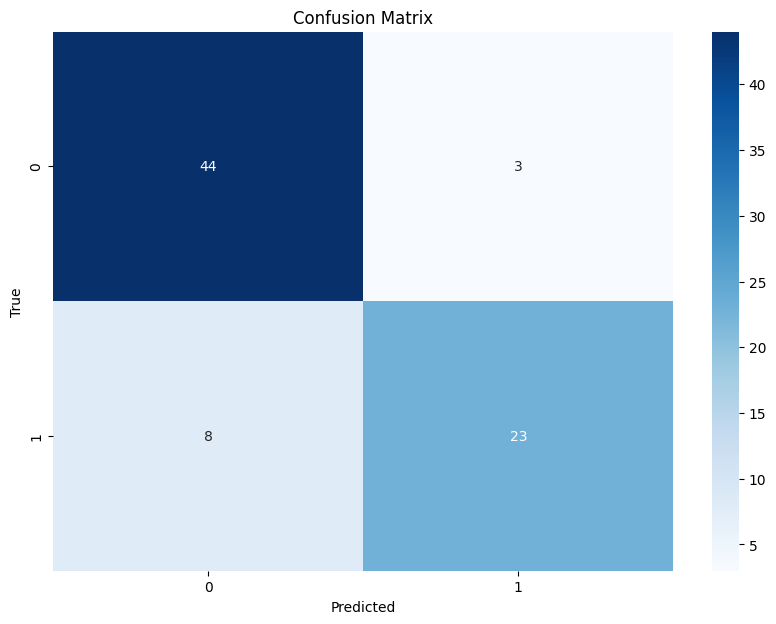


Classification Report for output1:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89        47
           1       0.88      0.74      0.81        31

    accuracy                           0.86        78
   macro avg       0.87      0.84      0.85        78
weighted avg       0.86      0.86      0.86        78


Confusion Matrix for output2:


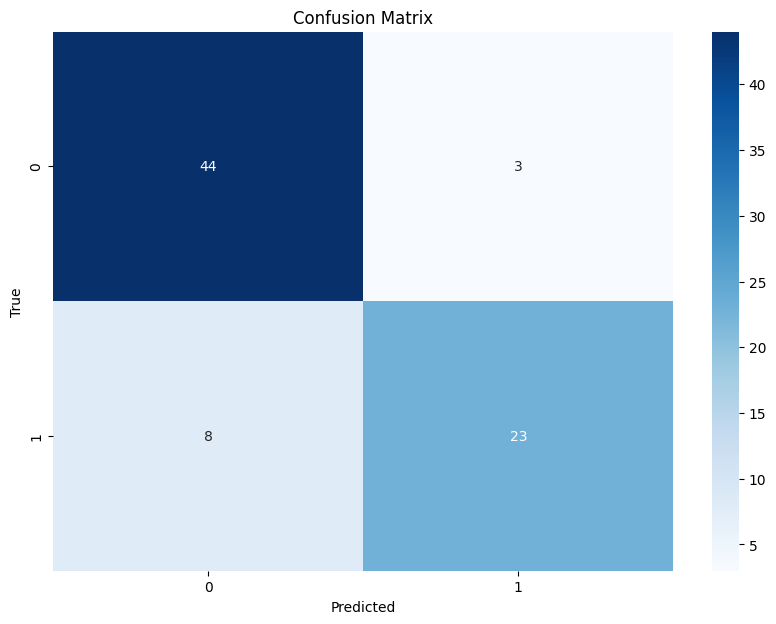


Classification Report for output2:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89        47
           1       0.88      0.74      0.81        31

    accuracy                           0.86        78
   macro avg       0.87      0.84      0.85        78
weighted avg       0.86      0.86      0.86        78


Class-wise Accuracy for output1: 85.90%

Class-wise Accuracy for output2: 85.90%


: 

In [ ]:
#state_dict = torch.load('birads12-45_resnet_18_wdcc.pth')
#model.load_state_dict(state_dict)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

model.eval()
all_labels = []
all_preds1 = []
all_preds2 = []

with torch.no_grad():
    for (img1, img2), labels in tqdm(test_loader, desc="Testing", leave=False):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        output1, output2, _ = model(img1, img2, labels)
        pred1 = output1.argmax(dim=1)
        pred2 = output2.argmax(dim=1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds1.extend(pred1.cpu().numpy())
        all_preds2.extend(pred2.cpu().numpy())

cm1 = confusion_matrix(all_labels, all_preds1)
print("\nConfusion Matrix for output1:")
plot_confusion_matrix(cm1, classes=[0, 1])  
print("\nClassification Report for output1:")
print(classification_report(all_labels, all_preds1, target_names=[str(i) for i in range(len(cm1))]))

cm2 = confusion_matrix(all_labels, all_preds2)
print("\nConfusion Matrix for output2:")
plot_confusion_matrix(cm2, classes=[0, 1])  

print("\nClassification Report for output2:")
print(classification_report(all_labels, all_preds2, target_names=[str(i) for i in range(len(cm2))]))

accuracy1 = accuracy_score(all_labels, all_preds1)
print(f"\nClass-wise Accuracy for output1: {accuracy1*100:.2f}%")
accuracy2 = accuracy_score(all_labels, all_preds2)
print(f"\nClass-wise Accuracy for output2: {accuracy2*100:.2f}%")

In [13]:
base_model = models.resnet50(pretrained=True) 
ResNet50model = CNN_ResNet50(base_model).to(device)
num_epochs = 10 
learning_rate = 0.0001
best_val_loss = float('inf')  
optimizer = optim.Adam(ResNet50model.parameters(), lr=learning_rate)
best_model_path = "birads12-45_resnet_50_wdcc.pth"
ResNet50model
model = ResNet50model

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for (img1, img2), labels in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        optimizer.zero_grad()
        output1, output2, _ = model(img1, img2, labels)
        loss1, loss2 = weight_loss(output1, output2, labels)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"\nEpoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct1 = 0
        correct2 = 0
        total = 0
        
        for (img1, img2), labels in tqdm(valid_loader, desc="Validation", leave=False):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            output1, output2, _ = model(img1, img2, labels)
            loss1, loss2 = weight_loss(output1, output2, labels)
            val_loss += (loss1 + loss2).item()
            pred1 = output1.argmax(dim=1)
            pred2 = output2.argmax(dim=1)
            correct1 += (pred1 == labels).sum().item()
            correct2 += (pred2 == labels).sum().item()
            total += labels.size(0)
            
        avg_val_loss = val_loss / len(valid_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print("Best model saved!")
        
        print(f"Validation Loss: {val_loss/len(valid_loader):.4f}, "
              f"Accuracy1: {correct1/total*100:.2f}%, Accuracy2: {correct2/total*100:.2f}%")


Epoch [1/10], Loss: 1.3045


Best model saved!
Validation Loss: 0.9781, Accuracy1: 77.00%, Accuracy2: 77.00%



Epoch [2/10], Loss: 1.0426


Validation Loss: 1.2841, Accuracy1: 73.00%, Accuracy2: 73.33%



Epoch [3/10], Loss: 0.8934


Best model saved!
Validation Loss: 0.8149, Accuracy1: 82.67%, Accuracy2: 82.67%



Epoch [4/10], Loss: 0.8169


Validation Loss: 0.8595, Accuracy1: 82.33%, Accuracy2: 82.33%



Epoch [5/10], Loss: 0.7485


Best model saved!
Validation Loss: 0.6731, Accuracy1: 86.33%, Accuracy2: 86.33%



Epoch [6/10], Loss: 0.7337


Validation Loss: 0.6889, Accuracy1: 85.33%, Accuracy2: 85.00%



Epoch [7/10], Loss: 0.6858


Validation Loss: 0.7357, Accuracy1: 87.67%, Accuracy2: 87.33%



Epoch [8/10], Loss: 0.6610


Validation Loss: 0.7926, Accuracy1: 84.33%, Accuracy2: 84.00%



Epoch [9/10], Loss: 0.6500


Best model saved!
Validation Loss: 0.6587, Accuracy1: 85.00%, Accuracy2: 84.67%



Epoch [10/10], Loss: 0.6083


Best model saved!
Validation Loss: 0.6456, Accuracy1: 86.00%, Accuracy2: 86.33%



Confusion Matrix for output1:


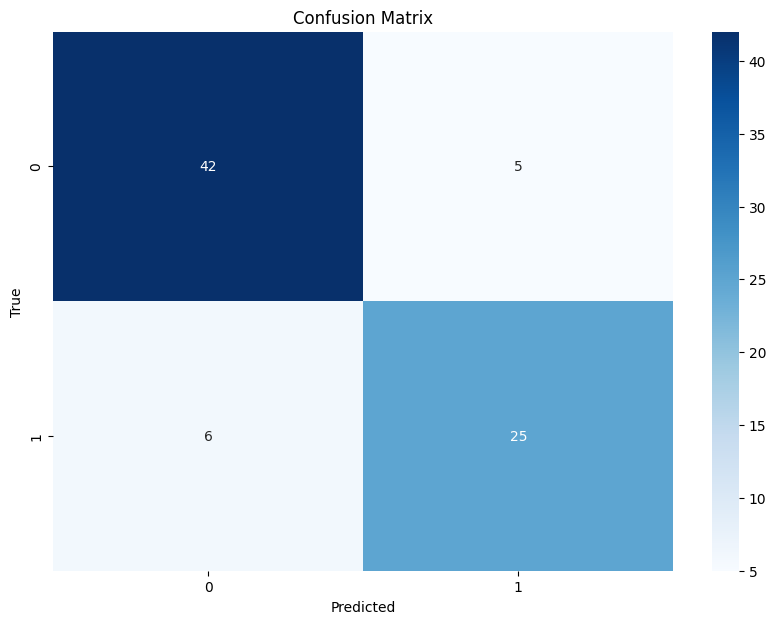


Classification Report for output1:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88        47
           1       0.83      0.81      0.82        31

    accuracy                           0.86        78
   macro avg       0.85      0.85      0.85        78
weighted avg       0.86      0.86      0.86        78


Confusion Matrix for output2:


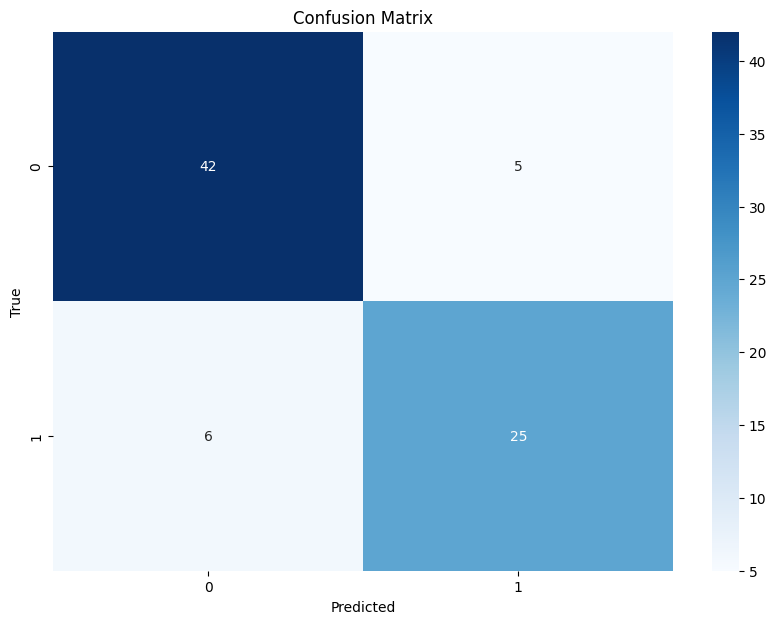


Classification Report for output2:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88        47
           1       0.83      0.81      0.82        31

    accuracy                           0.86        78
   macro avg       0.85      0.85      0.85        78
weighted avg       0.86      0.86      0.86        78


Class-wise Accuracy for output1: 85.90%

Class-wise Accuracy for output2: 85.90%


In [ ]:
state_dict = torch.load(r'birads12-45_resnet_50_wdcc.pth')
model.load_state_dict(state_dict)

model.eval()
all_labels = []
all_preds1 = []
all_preds2 = []

with torch.no_grad():
    for (img1, img2), labels in tqdm(test_loader, desc="Testing", leave=False):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        output1, output2, _ = model(img1, img2, labels)
        pred1 = output1.argmax(dim=1)
        pred2 = output2.argmax(dim=1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds1.extend(pred1.cpu().numpy())
        all_preds2.extend(pred2.cpu().numpy())

cm1 = confusion_matrix(all_labels, all_preds1)
print("\nConfusion Matrix for output1:")
plot_confusion_matrix(cm1, classes=[0, 1])  
print("\nClassification Report for output1:")
print(classification_report(all_labels, all_preds1, target_names=[str(i) for i in range(len(cm1))]))

cm2 = confusion_matrix(all_labels, all_preds2)
print("\nConfusion Matrix for output2:")
plot_confusion_matrix(cm2, classes=[0, 1])  

print("\nClassification Report for output2:")
print(classification_report(all_labels, all_preds2, target_names=[str(i) for i in range(len(cm2))]))

accuracy1 = accuracy_score(all_labels, all_preds1)
print(f"\nClass-wise Accuracy for output1: {accuracy1*100:.2f}%")
accuracy2 = accuracy_score(all_labels, all_preds2)
print(f"\nClass-wise Accuracy for output2: {accuracy2*100:.2f}%")

### ResNet18 and ResNet50 with normal classifier head

In [18]:
class CNN_ResNet18_2(nn.Module): 
    def __init__(self, model):
        super(CNN_ResNet18_2, self).__init__()
        self.resnet_layer = nn.Sequential(*list(model.children())[:-1])
        self.avp_pooling = nn.AdaptiveAvgPool2d((1, 1)) 
        self.linear_layer1 = nn.Linear(1024, 1024)
        self.linear_layer2 = nn.Linear(1024, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        
    def forward(self, img1, img2):
        # first image
        x1 = self.resnet_layer(img1)
        x1 = self.avp_pooling(x1).view(x1.size()[0], -1)

        # second image
        x2 = self.resnet_layer(img2)
        x2 = self.avp_pooling(x2).view(x2.size()[0], -1)

        x = torch.cat((x1, x2), dim=1)
        x = self.dropout(x)
        x = self.relu(self.linear_layer1(x))
        x = self.dropout(x)
        x = self.relu(self.linear_layer2(x))

        return x

In [19]:
class CNN_ResNet50_2(nn.Module): 
    def __init__(self, model):
        super(CNN_ResNet50_2, self).__init__()
        self.resnet_layer = nn.Sequential(*list(model.children())[:-1])
        self.avp_pooling = nn.AdaptiveAvgPool2d((1, 1)) 
        self.linear_layer1 = nn.Linear(4096, 1024)
        self.linear_layer2 = nn.Linear(1024, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        
    def forward(self, img1, img2):
        # first image
        x1 = self.resnet_layer(img1)
        x1 = self.avp_pooling(x1).view(x1.size()[0], -1)

        # second image
        x2 = self.resnet_layer(img2)
        x2 = self.avp_pooling(x2).view(x2.size()[0], -1)

        x = torch.cat((x1, x2), dim=1)
        x = self.dropout(x)
        x = self.relu(self.linear_layer1(x))
        x = self.dropout(x)
        x = self.relu(self.linear_layer2(x))

        return x

In [20]:
base_model = models.resnet18(pretrained=True) 
ResNet18model2 = CNN_ResNet18_2(base_model).to(device)
model2 = ResNet18model2
num_epochs = 10 
learning_rate = 0.0001
best_val_loss = float('inf')  
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)
best_model_path = "birads12-45_resnet_18_normal.pth"
criterion = torch.nn.CrossEntropyLoss()
model2

CNN_ResNet18_2(
  (resnet_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [24]:
for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    
    for (img1, img2), labels in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]"):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model2(img1, img2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")
    
    # Validation loop
    model2.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for (img1, img2), labels in tqdm(valid_loader, desc="Validation"):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            outputs = model2(img1, img2)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(valid_loader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model2.state_dict(), best_model_path)
        print("Best model saved!")

print("Training finished!")

Epoch [1/10]:   0%|          | 0/147 [00:01<?, ?it/s]


KeyboardInterrupt: 

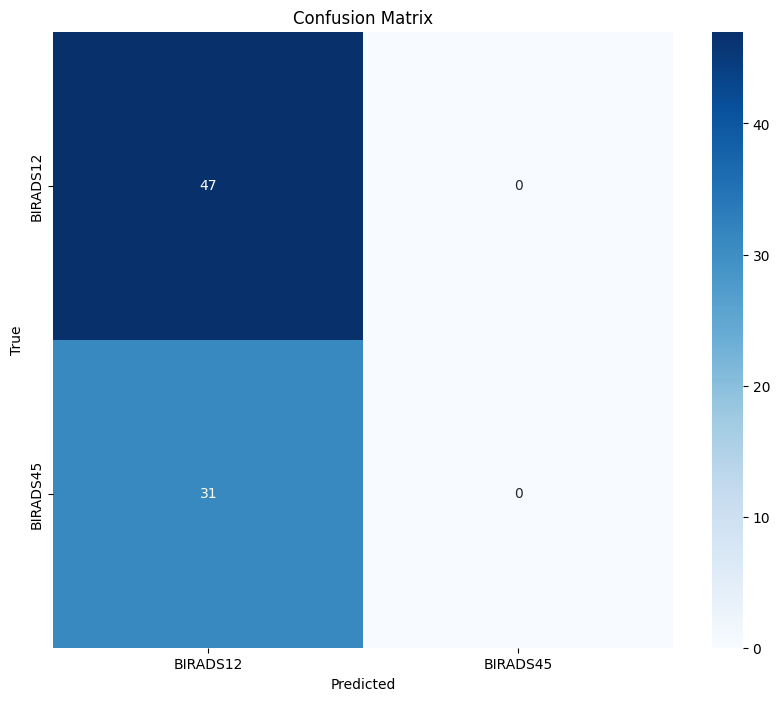

              precision    recall  f1-score   support

    BIRADS12       0.60      1.00      0.75        47
    BIRADS45       0.00      0.00      0.00        31

    accuracy                           0.60        78
   macro avg       0.30      0.50      0.38        78
weighted avg       0.36      0.60      0.45        78

Overall Accuracy: 0.6026
Accuracy for class BIRADS12: 1.0000
Accuracy for class BIRADS45: 0.0000


In [ ]:
y_true = []
y_pred = []

state_dict = torch.load(r'birads12-45_resnet_18_normal.pth')
model2.load_state_dict(state_dict)

model2.eval()
class_names = ['BIRADS12', 'BIRADS45']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for inputs, labels in test_loader:

        inputs = [img.to(device) for img in inputs]
        labels = labels.to(device)

        outputs = model2(inputs[0], inputs[1])
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f'Overall Accuracy: {accuracy:.4f}')
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f'Accuracy for class {class_names[i]}: {acc:.4f}')

In [22]:
base_model = models.resnet50(pretrained=True) 
ResNet50model2 = CNN_ResNet50_2(base_model).to(device)
num_epochs = 10 
learning_rate = 0.0001
best_val_loss = float('inf')  
optimizer = optim.Adam(ResNet50model2.parameters(), lr=learning_rate)
best_model_path = "birads12-45_resnet_50_normal.pth"
criterion = torch.nn.CrossEntropyLoss()
model2 = ResNet50model2
ResNet50model2

CNN_ResNet50_2(
  (resnet_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

In [ ]:
for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    
    for (img1, img2), labels in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]"):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model2(img1, img2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")
    
    # Validation loop
    model2.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for (img1, img2), labels in tqdm(valid_loader, desc="Validation"):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            outputs = model2(img1, img2)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(valid_loader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model2.state_dict(), best_model_path)
        print("Best model saved!")

print("Training finished!")

Epoch [1/10]: 100%|██████████| 147/147 [06:38<00:00,  2.71s/it]


Epoch [1/10], Train Loss: 0.6909


Validation: 100%|██████████| 19/19 [00:19<00:00,  1.05s/it]


Validation Loss: 0.6931, Accuracy: 59.67%
Best model saved!


Epoch [2/10]: 100%|██████████| 147/147 [06:36<00:00,  2.70s/it]


Epoch [2/10], Train Loss: 0.6917


Validation: 100%|██████████| 19/19 [00:20<00:00,  1.05s/it]


Validation Loss: 0.6382, Accuracy: 59.67%
Best model saved!


Epoch [3/10]:  60%|█████▉    | 88/147 [04:03<02:43,  2.77s/it]


KeyboardInterrupt: 

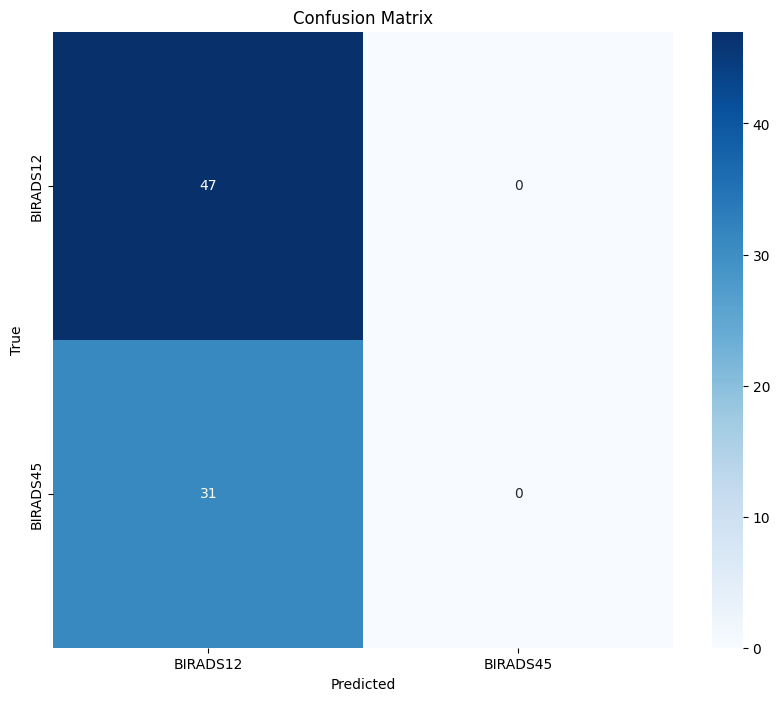

              precision    recall  f1-score   support

    BIRADS12       0.60      1.00      0.75        47
    BIRADS45       0.00      0.00      0.00        31

    accuracy                           0.60        78
   macro avg       0.30      0.50      0.38        78
weighted avg       0.36      0.60      0.45        78

Overall Accuracy: 0.6026
Accuracy for class BIRADS12: 1.0000
Accuracy for class BIRADS45: 0.0000


In [ ]:
y_true = []
y_pred = []

state_dict = torch.load(r'birads12-45_resnet_50_normal.pth')
model2.load_state_dict(state_dict)

model2.eval()
class_names = ['BIRADS12', 'BIRADS45']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for inputs, labels in test_loader:

        inputs = [img.to(device) for img in inputs]
        labels = labels.to(device)

        outputs = model2(inputs[0], inputs[1])
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f'Overall Accuracy: {accuracy:.4f}')
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f'Accuracy for class {class_names[i]}: {acc:.4f}')